In [460]:
from IPython.display import Image

import keras
from keras.datasets import cifar10
from keras import backend as K
from keras.layers import Lambda, Input, Dense, Conv2D, \
    Dropout, Conv2DTranspose, MaxPooling2D, Flatten, Reshape, UpSampling2D
from keras.models import Model
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pydot
import networkx as nx
from itertools import product

In [461]:
# CIFAR10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [462]:
img_rows, img_cols, num_channels = x_train.shape[1:]
original_dim = img_rows * img_cols

In [463]:
batch_size = 128
latent_dim = 4
epochs = 15

In [464]:
#x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
#x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, num_channels)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [465]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [466]:
inputs = Input(shape=input_shape,name='encoder_input')

In [467]:
l1 = Conv2D( 32, (5,5), strides=2, activation='relu', padding='same' )(inputs)
l2 = Conv2D( 32, (3,3), strides=2, activation='relu', padding='same' )(l1)
l2b = MaxPooling2D(pool_size=(2,2))(l2)
#l2bb = Dropout(0.25)(l2b)

l2c = Conv2D( 64, (3,3), strides=1, activation='relu', padding='same' )(l2b)
l2d = Conv2D( 64, (3,3), strides=1, activation='relu', padding='same' )(l2c)
#l2e = MaxPooling2D(pool_size=(2,2))(l2d)
#l2ee = Dropout(0.25)(l2d)

conv_shape = K.int_shape(l2d)

In [468]:
l3 = Flatten()(l2d)

In [469]:
l5 = Dense( 256, activation='relu' )(l3)

In [470]:
z_mean = Dense(latent_dim, name='z_mean')(l5)
z_log_var = Dense(latent_dim, name='z_log_var')(l5)

In [471]:
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

In [472]:
encoder = Model( inputs, [z_mean,z_log_var,z], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_81 (Conv2D)              (None, 16, 16, 32)   2432        encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_82 (Conv2D)              (None, 8, 8, 32)     9248        conv2d_81[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_30 (MaxPooling2D) (None, 4, 4, 32)     0           conv2d_82[0][0]                  
__________________________________________________________________________________________________
conv2d_83 

In [473]:
plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

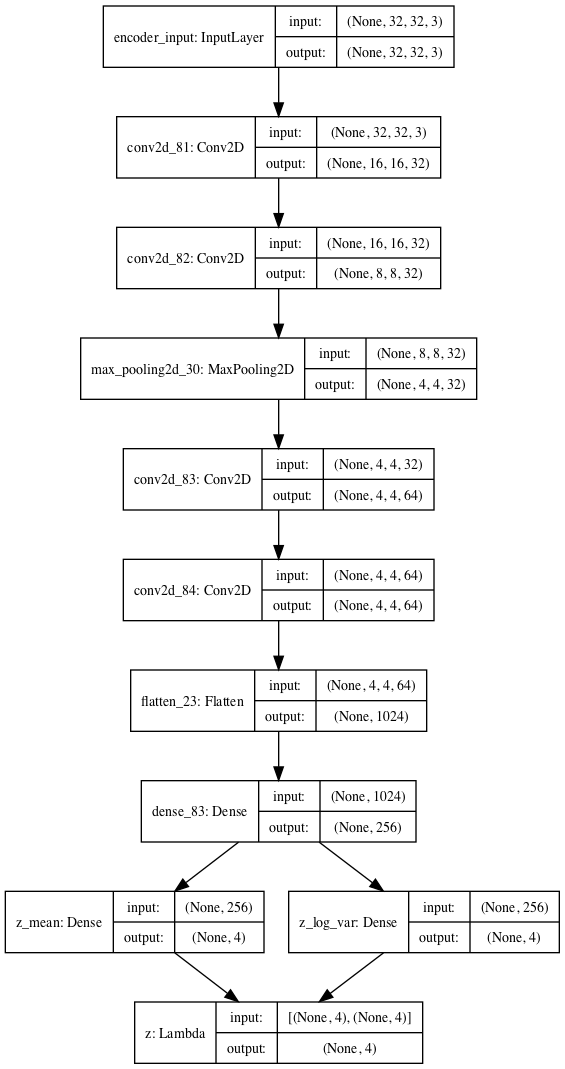

In [474]:
display(Image('vae_cnn_encoder.png'))

In [475]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
m0 = Dense(256, activation='relu')(latent_inputs)
m1 = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(m0)
m2 = Reshape(conv_shape[1:])(m1)
m2b = Conv2DTranspose(64,(3,3),strides=1,activation='relu',padding='same')(m2)
m2c = Conv2DTranspose(64,(3,3),strides=1,activation='relu',padding='same')(m2b)
m3 = Conv2DTranspose(32,(3,3),strides=2,activation='relu',padding='same')(m2c)
m4 = Conv2DTranspose(32,(3,3),strides=2,activation='relu',padding='same')(m3)
outputs = Conv2DTranspose(3,(5,5),strides=2,activation='sigmoid',padding='same',name='decoder_output')(m4)

In [476]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 4)                 0         
_________________________________________________________________
dense_84 (Dense)             (None, 256)               1280      
_________________________________________________________________
dense_85 (Dense)             (None, 1024)              263168    
_________________________________________________________________
reshape_32 (Reshape)         (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_transpose_115 (Conv2D (None, 4, 4, 64)          36928     
_________________________________________________________________
conv2d_transpose_116 (Conv2D (None, 4, 4, 64)          36928     
_________________________________________________________________
conv2d_transpose_117 (Conv2D (None, 8, 8, 32)          18464     
__________

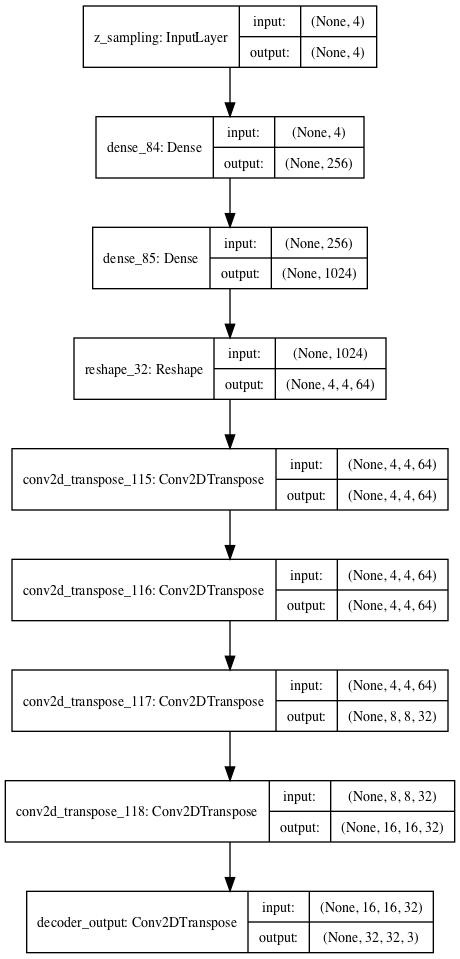

In [477]:
display(Image('vae_cnn_decoder.png'))

In [478]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_cnn')

In [479]:
models = (encoder, decoder)
reconstruction_loss = binary_crossentropy(K.flatten(inputs),K.flatten(outputs))
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()
plot_model(vae,to_file='vae_cnn.png',show_shapes=True)

/Users/jon/data/sandbox/keras/ve/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Output "decoder" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "decoder" during training.
  if __name__ == '__main__':


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 32, 32, 3)         0         
_________________________________________________________________
encoder (Model)              [(None, 4), (None, 4), (N 331560    
_________________________________________________________________
decoder (Model)              (None, 32, 32, 3)         368419    
Total params: 699,979
Trainable params: 699,979
Non-trainable params: 0
_________________________________________________________________


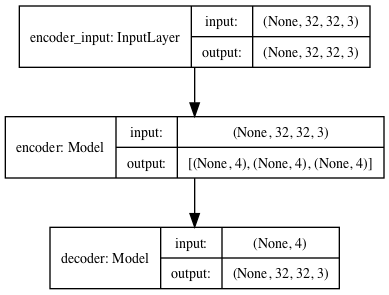

In [480]:
display(Image('vae_cnn.png'))

In [481]:
vae.fit(x_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(x_test, None))
vae.save_weights('vae_cnn_mnist.h5')

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 44s 876us/step - loss: 669.3811 - val_loss: 646.4303
Epoch 2/15
50000/50000 [==============================] - 41s 826us/step - loss: 645.0371 - val_loss: 645.3529
Epoch 3/15
50000/50000 [==============================] - 40s 809us/step - loss: 644.2868 - val_loss: 645.0081
Epoch 4/15
50000/50000 [==============================] - 41s 814us/step - loss: 643.8557 - val_loss: 644.5106
Epoch 5/15
50000/50000 [==============================] - 40s 797us/step - loss: 643.4336 - val_loss: 644.1355
Epoch 6/15
50000/50000 [==============================] - 41s 819us/step - loss: 642.9048 - val_loss: 643.3982
Epoch 7/15
50000/50000 [==============================] - 41s 816us/step - loss: 642.2845 - val_loss: 642.8127
Epoch 8/15
50000/50000 [==============================] - 40s 802us/step - loss: 641.9329 - val_loss: 642.5339
Epoch 9/15
50000/50000 [==============================] - 41s 

In [482]:
z_mean,_,_ = encoder.predict(x_test,batch_size=batch_size)

In [483]:
y_test.shape

(10000, 1)

In [484]:
d = pd.DataFrame( {'x':z_mean[:,0],'y':z_mean[:,1],'label':y_test[:,0]} )

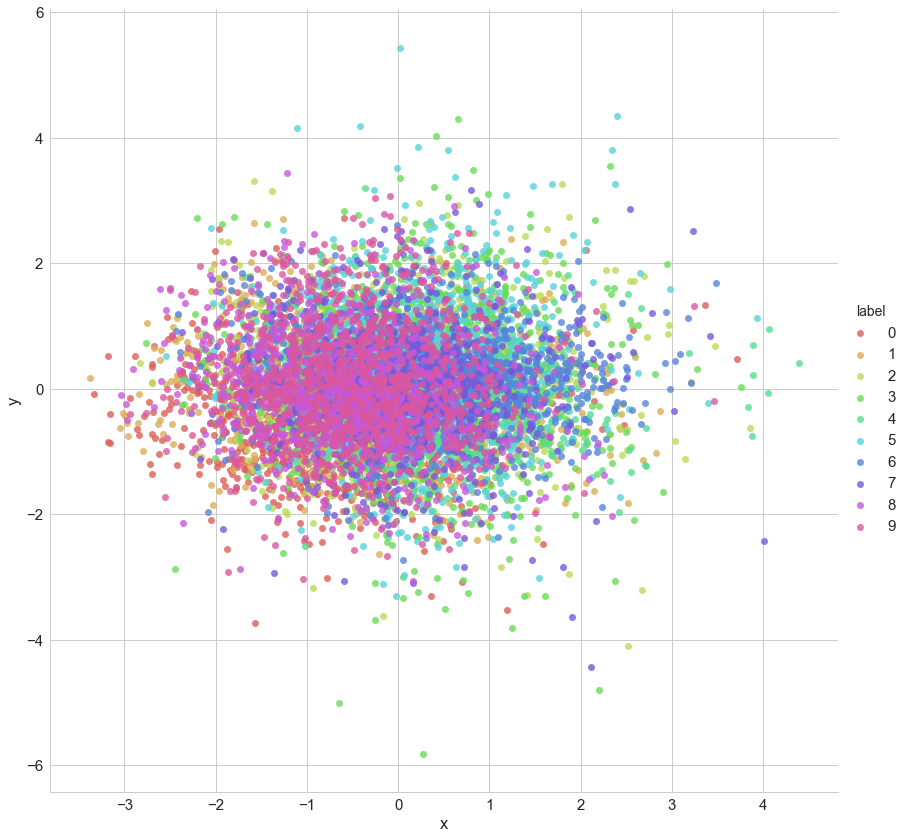

In [485]:
sns.set(rc={'figure.figsize':(12,12)})
sns.set_context('notebook',font_scale=1.5)
sns.set_style('whitegrid')
with sns.color_palette('hls',10):
    sns.lmplot(x="x",y="y",data=d,hue='label',fit_reg=False,size=12)

In [486]:
#
# TODO: create three-dimensional image array (32*32*3)
# (plot with imshow)
#
n = 30
figure = np.zeros((img_rows * n, img_cols * n, 3))
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]+[0.0]*(latent_dim-2)])
        x_decoded = decoder.predict(z_sample)
        figure[i * img_rows: (i + 1) * img_rows,
               j * img_cols: (j + 1) * img_cols,
               :] = x_decoded[0]

(-0.5, 959.5, 959.5, -0.5)

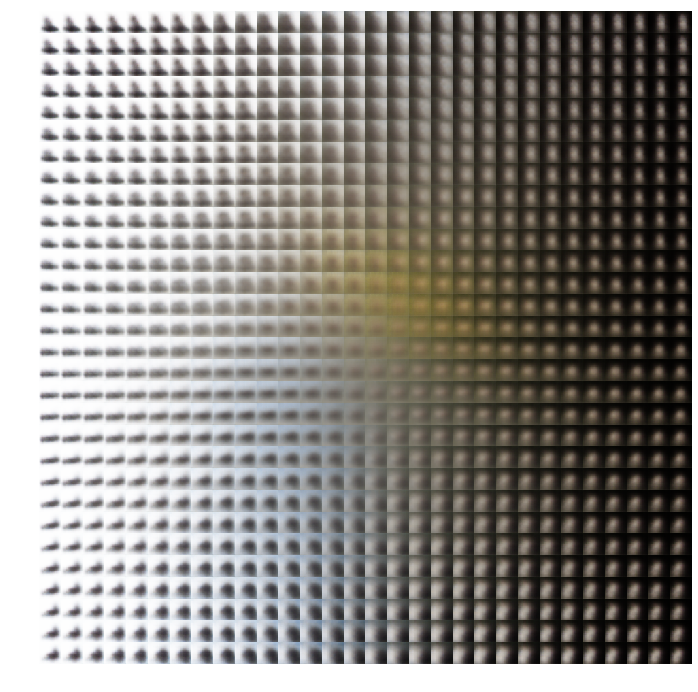

In [487]:
fig, ax = plt.subplots()
ax.imshow(figure)
ax.axis('off')

In [488]:
# establish grid in latent space
_,_,z = encoder.predict(x_train)
z_limits = np.array( [ [ np.percentile(z[:,i],10), np.percentile(z[:,i],90) ] for i in range(latent_dim) ] )
# create nodes using a discretized latent space (-1,1)^n
min_z, max_z = -1,1
g = nx.Graph()
latent_samples = [3]*latent_dim
latent_points = np.array(list(product(*[np.linspace(min_z,max_z,latent_samples[i]) for i in range(latent_dim)])))

In [489]:
for i in range(latent_points.shape[0]):
    alpha = (latent_points[i,:]-min_z)/(max_z-min_z)
    true_z = alpha * (z_limits[:,1] - z_limits[:,0]) + z_limits[:,0]
    z_sample = np.array( [true_z] )
    x_decoded = decoder.predict(z_sample)
    k = tuple( latent_points[i,j] for j in range(latent_dim) )
    g.add_node( k )
    g.nodes[k]['image_data'] = x_decoded[0]

In [490]:
maxsq = max_z*max_z + max_z/2.0
for i in range(latent_points.shape[0]):
    k1 = tuple( latent_points[i,k] for k in range(latent_dim) )
    for j in range(i+1,latent_points.shape[0]):
        dl = latent_points[i]-latent_points[j]
        if np.dot(dl,dl) < maxsq:
            k2 = tuple( latent_points[j,k] for k in range(latent_dim) )
            g.add_edge( k1, k2 )

In [491]:
gp = nx.nx_pydot.to_pydot(g)

In [492]:
import PIL
import PIL.Image
import base64
import os

# unfortunately graphviz doesn't support img from data
def get_base64_data( img_data ):
    img = PIL.Image.fromarray((img_data*255.0).astype('uint8'))
    img = img.convert('RGB')
    img.save('tmp.png')
    with open("tmp.png", "rb") as infile:
        enc = base64.b64encode(infile.read())
    return enc.decode('utf-8')

os.system('mkdir -p node_images')

def generate_image_file( _id, img_data ):
    data = (img_data*255.0).astype('uint8')
    #rgb_data = data[:,:,0] * (1<<16) + data[:,:,1] * (1<<8) + data[:,:,2]
    img = PIL.Image.fromarray(data,mode='RGB')
    f = os.path.abspath('node_images/%s.png'%_id)
    img.save(f)
    return f

In [493]:
for i,(n,m) in enumerate(zip( gp.get_nodes(), g.nodes() )):
    dist = sum(x*x for x in eval(n.get_name().strip('"')))
    node_color = '%.2x' % (int(dist/latent_dim * 128.0 + 127.0))
    img = generate_image_file( i, g.nodes[m]['image_data'] )
    n.set_label( '<<table border="0"><tr><td><img src="%s"/></td></tr></table>>'%img )
    n.set_width(0.5)
    n.set_height(0.5)
    n.set_fixedsize(True)
    n.set_color('#e0e0ff')
    n.set_fillcolor('#%se0fb'%node_color)
    n.set_style('filled')
for e in gp.get_edges():
    e.set_color('#a0f0a0')

In [494]:
gp.set_overlap(False)
gp.set_outputorder('edgesfirst')
graphviz_prog = ['fdp','-GK=0.5']
graphviz_prog = ['twopi','-Granksep=0.72']
gp.write_png('tst.png',prog=graphviz_prog)

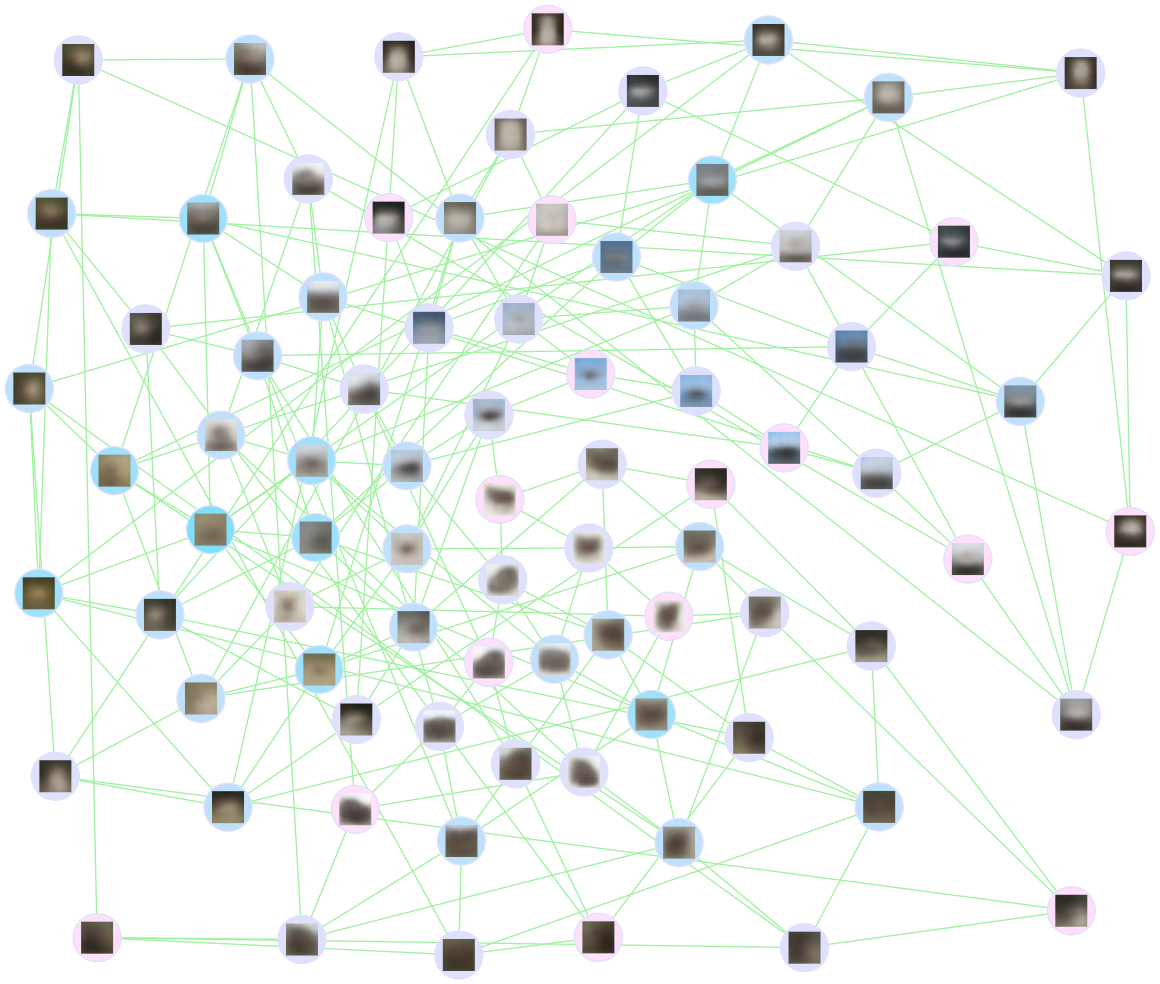

In [495]:
display(Image('tst.png'))

In [496]:
x_train.shape

(50000, 32, 32, 3)

In [498]:
x_train[:,:,:,0].mean() * 255.0

125.30691727995872